In [122]:
import matplotlib.pyplot as plt
import sklearn.feature_selection
from classes.LinearModelsSM import LinearModelsSM
import res.dicts
import res.functs
import pandas as pd
import matplotlib.pyplot
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy
from sklearn.preprocessing import StandardScaler, PowerTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***
First of all, I'm going to read the dataset and shuffle it right in the beginning - for further CV comfort.
***

In [123]:
data = pd.read_csv(r"../csv/DiamondsPrices2022.csv")
data = data.sample(frac=1)
data

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
45286,45287,0.51,Premium,G,VS1,62.1,58.0,1662,5.12,5.09,3.17
40516,40517,0.44,Ideal,I,VVS1,60.9,56.0,1145,4.90,4.96,3.00
30047,30048,0.41,Premium,G,SI1,62.7,58.0,719,4.70,4.74,2.96
10274,10275,1.07,Ideal,G,SI2,62.1,55.0,4752,6.54,6.61,4.08
8656,8657,0.90,Very Good,H,VS1,62.1,57.0,4455,6.17,6.23,3.85
...,...,...,...,...,...,...,...,...,...,...,...
46773,46774,0.52,Ideal,G,VS1,61.9,55.5,1803,5.13,5.16,3.18
8199,8200,1.04,Premium,H,SI2,58.6,60.0,4368,6.67,6.63,3.90
2598,2599,0.90,Good,E,SI2,62.0,63.0,3218,6.09,6.14,3.79
38766,38767,0.31,Ideal,E,VVS2,61.0,56.0,1046,4.43,4.39,2.69


The Unnamed: 0 column seems to be just ID. From the nature of the data it doesn't seem to have any predictive power, so I am going to get rid of it:

In [124]:
data = data.drop(columns=["Unnamed: 0"])
data

,carat,cut,color,clarity,depth,table,price,x,y,z
45286,0.51,Premium,G,VS1,62.1,58.0,1662,5.12,5.09,3.17
40516,0.44,Ideal,I,VVS1,60.9,56.0,1145,4.90,4.96,3.00
30047,0.41,Premium,G,SI1,62.7,58.0,719,4.70,4.74,2.96
10274,1.07,Ideal,G,SI2,62.1,55.0,4752,6.54,6.61,4.08
8656,0.90,Very Good,H,VS1,62.1,57.0,4455,6.17,6.23,3.85
...,...,...,...,...,...,...,...,...,...,...
46773,0.52,Ideal,G,VS1,61.9,55.5,1803,5.13,5.16,3.18
8199,1.04,Premium,H,SI2,58.6,60.0,4368,6.67,6.63,3.90
2598,0.90,Good,E,SI2,62.0,63.0,3218,6.09,6.14,3.79
38766,0.31,Ideal,E,VVS2,61.0,56.0,1046,4.43,4.39,2.69


Let me now check the datatypes and missing values:

In [125]:
print(data.dtypes)

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object


In [126]:
print(data.isna().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


I'm going to define the dependent variable y, which is the price:

In [127]:
y = data['price']
data = data.drop(columns=['price'])

And let us check the distribution & descriptive statistics of this variable:

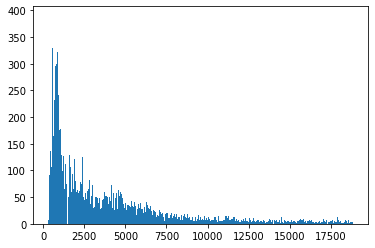

   Mean    Median    St. Dev.     Skew    Kurtosis    Durbin-Watson    JB-stat    JB-pvalue
-------  --------  ----------  -------  ----------  ---------------  ---------  -----------
3932.73      2401     3989.34  1.61848     5.17804          1.01618    34208.3            0


In [128]:
res.functs.descriptive(y, bins=30)

The above histogram doesn't look like a normal distribution at all, more like an exponential/gamma distribution of some kind. In the next step I'm going to separate the categorical and continous variables:

In [129]:
data_cat = data[['cut', 'color', 'clarity']]
data_con = data.drop(columns=['cut', 'color', 'clarity'])

all_con = pd.merge(y, data_con, left_index=True, right_index=True)

And then I'm going to check the scatterplots and histograms for both y and continous variables (for convinience only, technically all of it could be interpreted from one big pairplot):

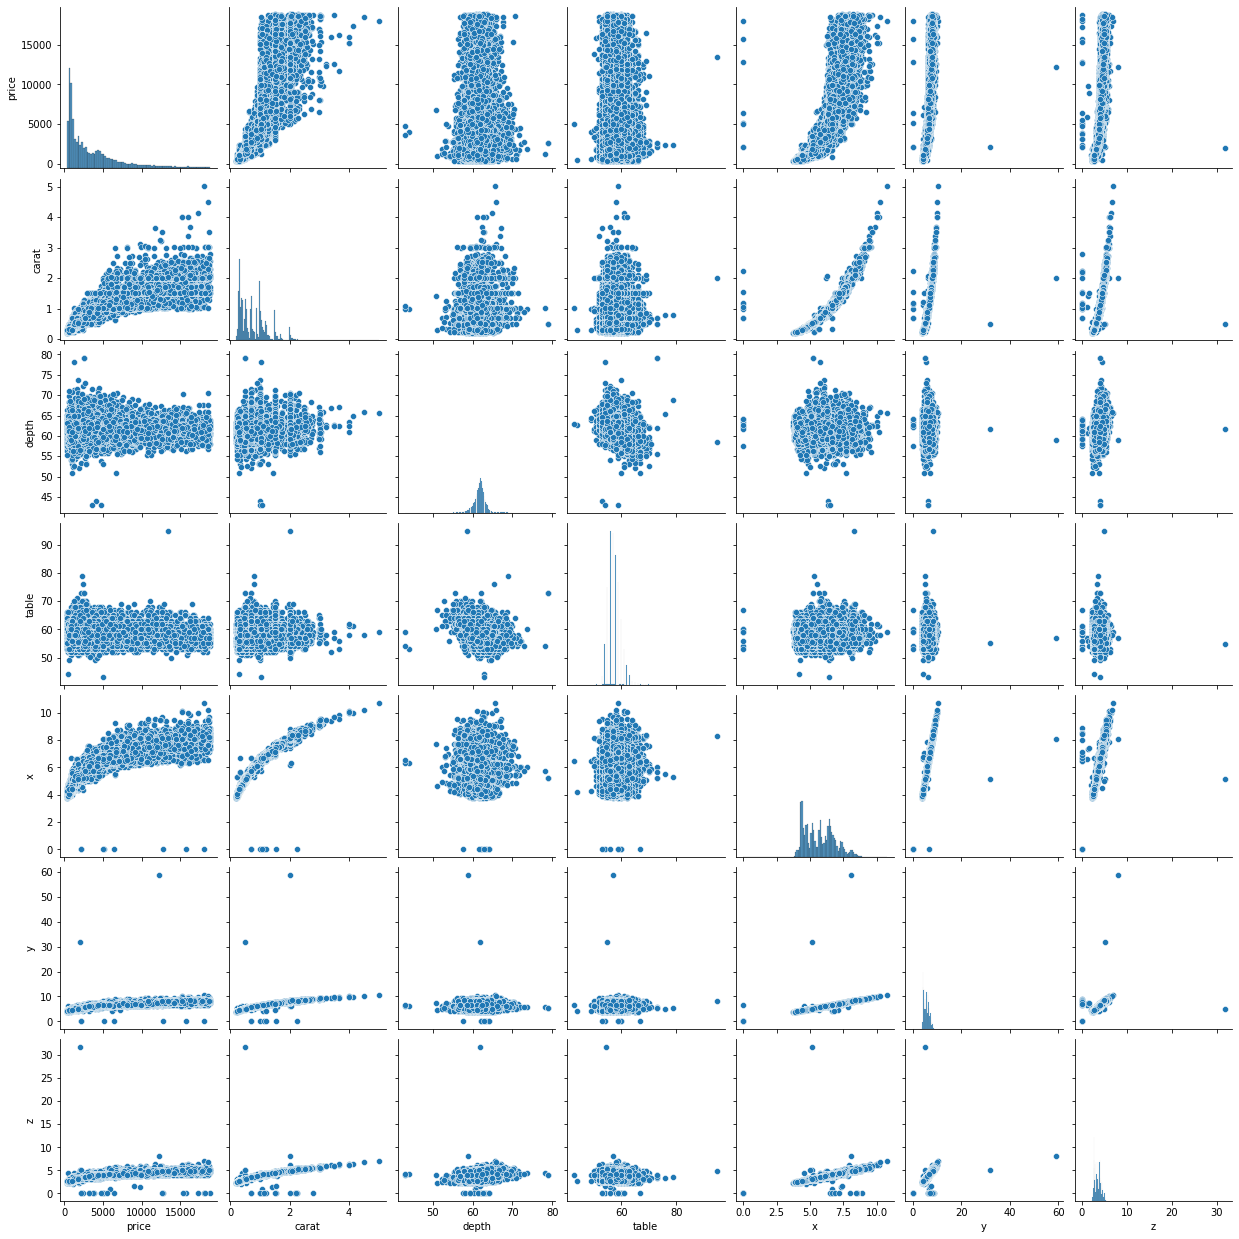

In [130]:
sns.pairplot(all_con)

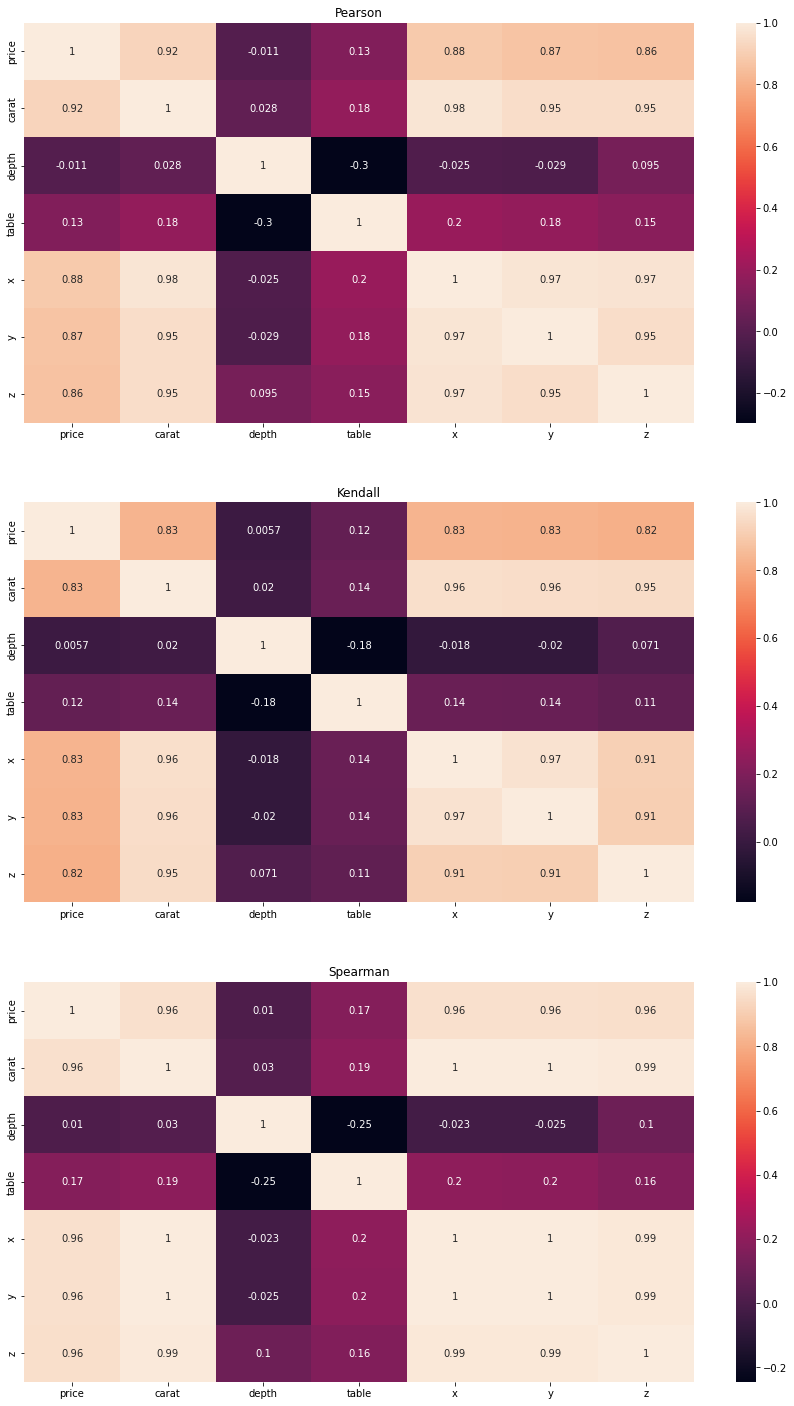

In [131]:
res.functs.correlations(all_con)

In [133]:
data_cat

,cut,color,clarity
45286,Premium,G,VS1
40516,Ideal,I,VVS1
30047,Premium,G,SI1
10274,Ideal,G,SI2
8656,Very Good,H,VS1
...,...,...,...
46773,Ideal,G,VS1
8199,Premium,H,SI2
2598,Good,E,SI2
38766,Ideal,E,VVS2


All the features seem to be dependent, however not all of them linearly. The distributions also do not look normal, arguably except for depth, y and z.

The nonlinearities in relation between the price and the features seem to be monotonous, it indicates that a power transformer might be able to fix it.

For now however let's check the spread of all the continous dependent variables:

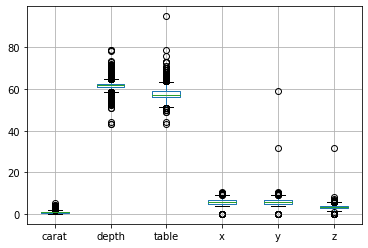

In [134]:
data_con.boxplot()
plt.show()

In [135]:
ypow = PowerTransformer(standardize=True).fit(y.values.reshape(-1,1))
y = pd.DataFrame(ypow.transform(y.values.reshape(-1,1)), columns=['price'])

pow = PowerTransformer(standardize=True).fit(data_con)
data_con = pd.DataFrame(pow.transform(data_con), columns=data_con.columns, index=data_con.index)

all_con = pd.DataFrame(PowerTransformer(standardize=True).fit_transform(all_con), columns=all_con.columns, index=all_con.index)

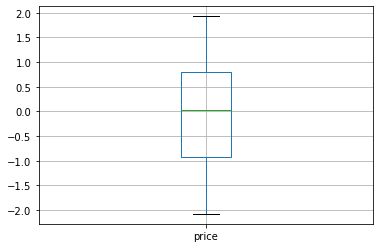

In [136]:
y.boxplot()
plt.show()

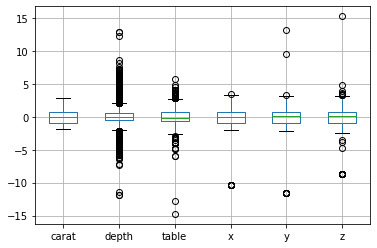

In [137]:
data_con.boxplot()
plt.show()

Standarization worked just fine, however some outliers can still be seen. I'm going to check the pairplots now:

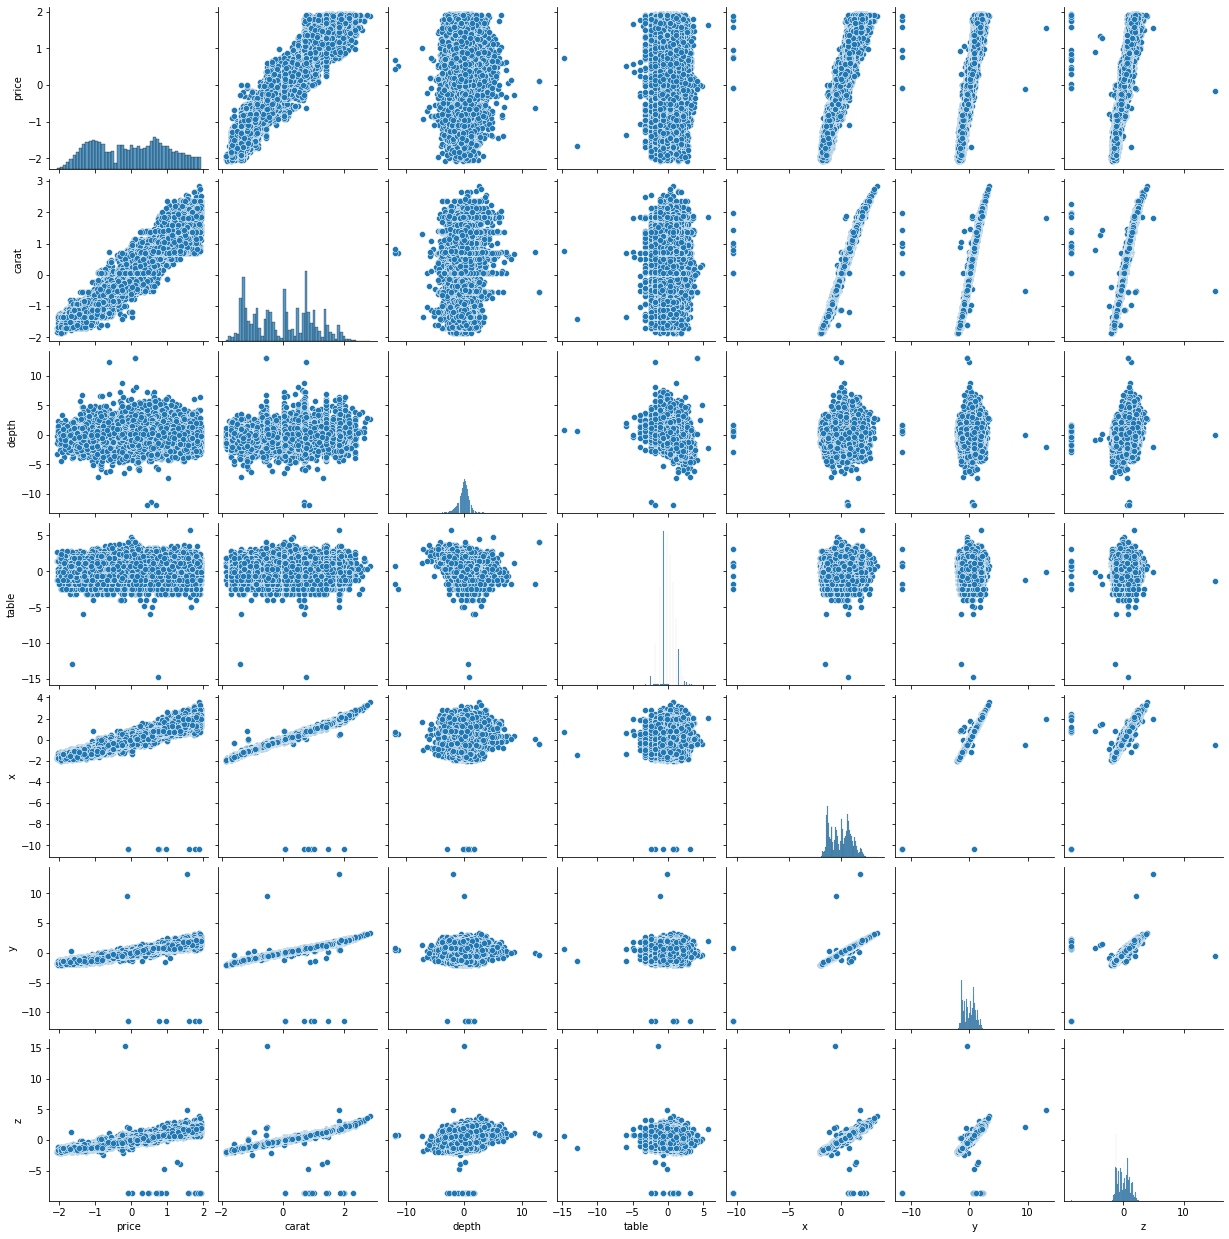

In [138]:
sns.pairplot(all_con)

Just as anticipated, the correlations have been linearized just by normalizing the distributions. Perfect! Unfortunately, not all the distributions seem to be perfectly normal, but this is as far as we can go.

Let us deal with categorical data now by creating dummy variables:

In [139]:
data_cat = pd.get_dummies(data_cat, drop_first=True)
print(data_cat)

       cut_Good  cut_Ideal  cut_Premium  cut_Very Good  color_E  color_F  \
45286         0          0            1              0        0        0   
40516         0          1            0              0        0        0   
30047         0          0            1              0        0        0   
10274         0          1            0              0        0        0   
8656          0          0            0              1        0        0   
...         ...        ...          ...            ...      ...      ...   
46773         0          1            0              0        0        0   
8199          0          0            1              0        0        0   
2598          1          0            0              0        1        0   
38766         0          1            0              0        1        0   
14174         0          0            1              0        0        0   

       color_G  color_H  color_I  color_J  clarity_IF  clarity_SI1  \
45286        1   

I'm going to merge the final X dataset now and proceed to training the models:

In [140]:
X = pd.merge(data_con, data_cat, left_index=True, right_index=True)
X

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
45286,-0.515227,0.238824,0.344127,-0.496638,-0.525709,-0.484799,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
40516,-0.764499,-0.597379,-0.620795,-0.714844,-0.656452,-0.751790,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
30047,-0.879886,0.660331,0.344127,-0.919651,-0.884398,-0.815991,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
10274,0.813489,0.238824,-1.173379,0.762667,0.823110,0.806225,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
8656,0.502674,0.238824,-0.116616,0.456548,0.513226,0.499480,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46773,-0.481720,0.098825,-0.890701,-0.486888,-0.456469,-0.469380,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
8199,0.762864,-2.174474,1.152341,0.867023,0.838985,0.567185,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
2598,0.502674,0.168793,2.133405,0.388499,0.437429,0.417458,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
38766,-1.307761,-0.528044,-0.620795,-1.206631,-1.265838,-1.264157,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


I'm going to train a set of linear models by the LinearModelsSM class, which I created in order to speed up the process of deployment. The class automatically splits the dataset to training and testing subsets, performs cross-validation if necessary and outputs error metrics.

In [141]:
model = LinearModelsSM(X, y)
model.train(intercept=True)

c:\users\micuk\pycharmprojects\makro\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
c:\users\micuk\pycharmprojects\makro\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
c:\users\micuk\pycharmprojects\makro\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
c:\users\micuk\pycharmprojects\makro\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was 

RESULTS FOR TRAINING SET:
+-------------+----------+----------+-----------+
|             |       R2 |      MSE |      RMSE |
+=============+==========+==========+===========+
| OLS         | 0.983687 | 0.127603 | 0.0162826 |
+-------------+----------+----------+-----------+
| Ridge       | 0.983687 | 0.127603 | 0.0162826 |
+-------------+----------+----------+-----------+
| Lasso       | 0.980636 | 0.139022 | 0.0193271 |
+-------------+----------+----------+-----------+
| Elastic Net | 0.979471 | 0.143145 | 0.0204906 |
+-------------+----------+----------+-----------+
| TheilSen    | 0.910015 | 0.299692 | 0.0898151 |
+-------------+----------+----------+-----------+
| Huber       | 0.98335  | 0.128912 | 0.0166183 |
+-------------+----------+----------+-----------+
| WLS         | 0.980073 | 0.14103  | 0.0198895 |
+-------------+----------+----------+-----------+
RESULTS FOR TESTING SET:
+-------------+----------+----------+-----------+
|             |       R2 |      MSE |      RMSE |

Ridge regression appeared to be the best among all the considered models. It's worth noting however, that all the error metrics (except for TheilSen regression) are extremely close to each other, which indicates that there is very low risk for overfitting, and therefore adding bias might be unjustified. Let us visualise lasso cross-validation to see, whether adding bias actually had significant impact on the model:

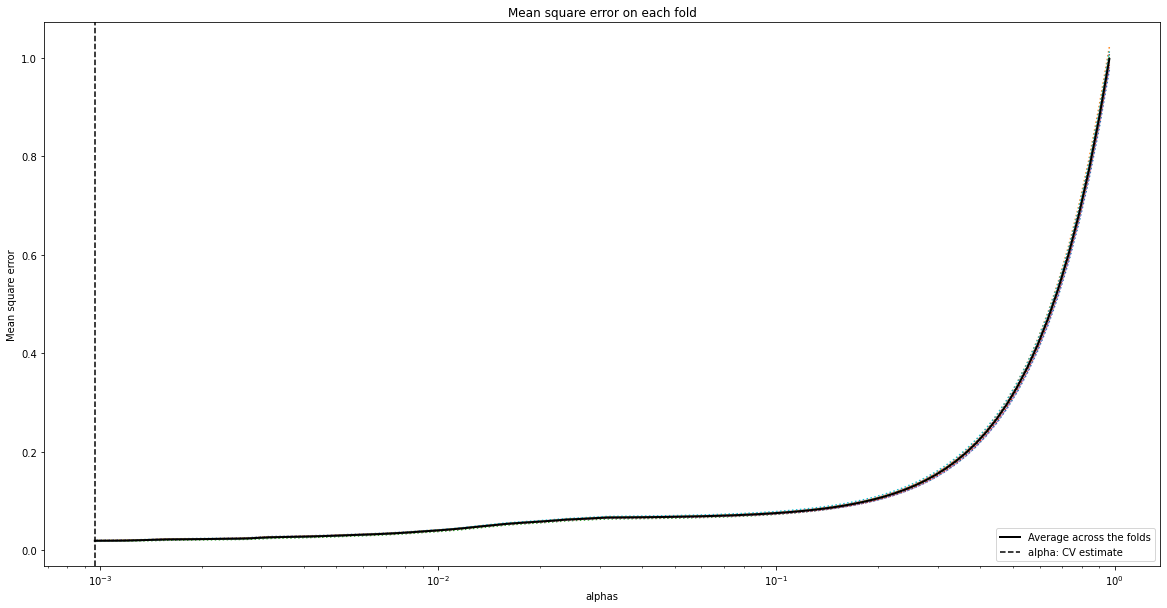

In [142]:
model.lasso_alphas()

As it can be seen, lasso CV selected the lowest possible alpha. Therefore I conclude, that despite that mild difference in testing metrics, adding bias does is not justified, I select OLS as the best model.

I'm going to check the predictions and residuals now to verify the assumptions:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


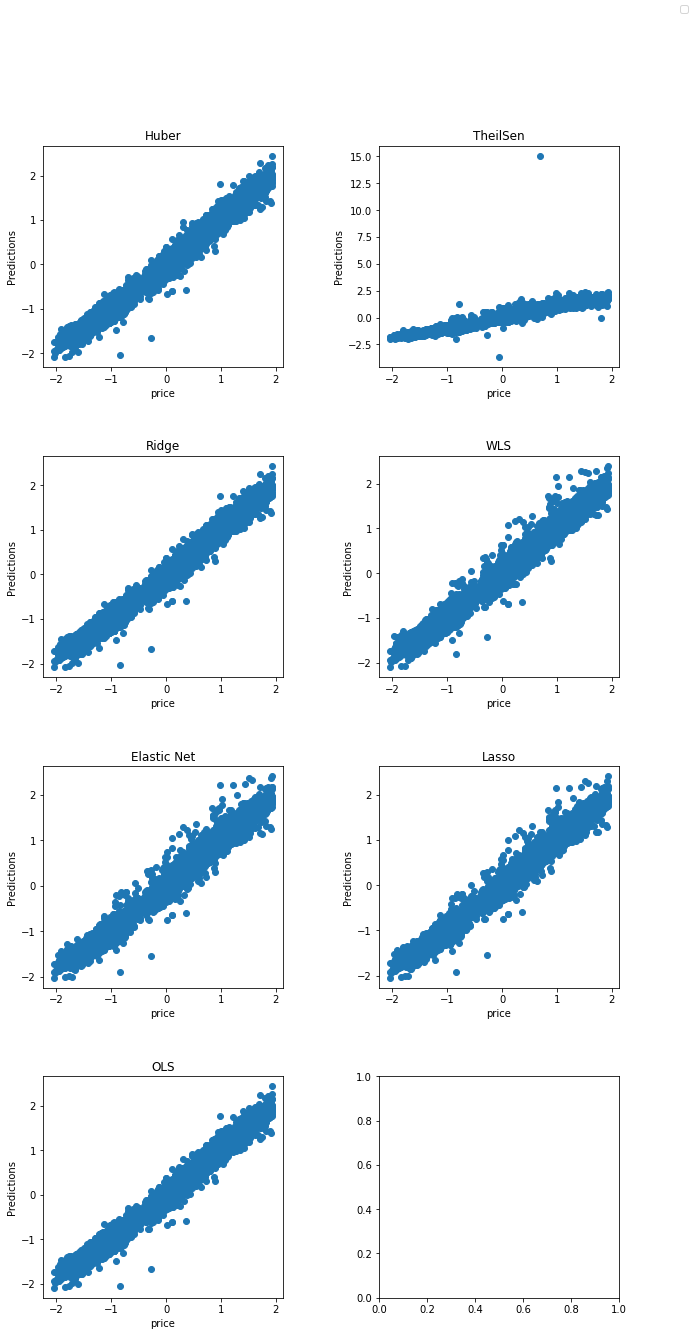

In [143]:
model.scatter(figsize=(10,20), dataset='test')

All the models seem very well fit, with few clearly visable outliers. OLS, which is our object of interest, seems to be well fit, but a lot of data on the scatterplot might disrupt the reality. It will be confirmed in further steps. I'm going to define the resids now:

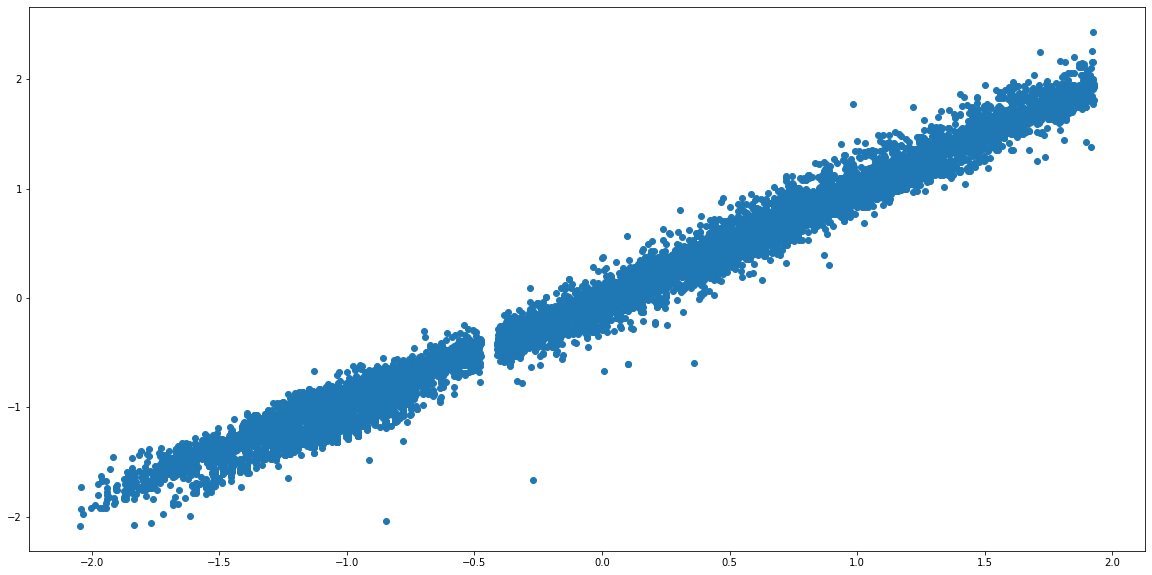

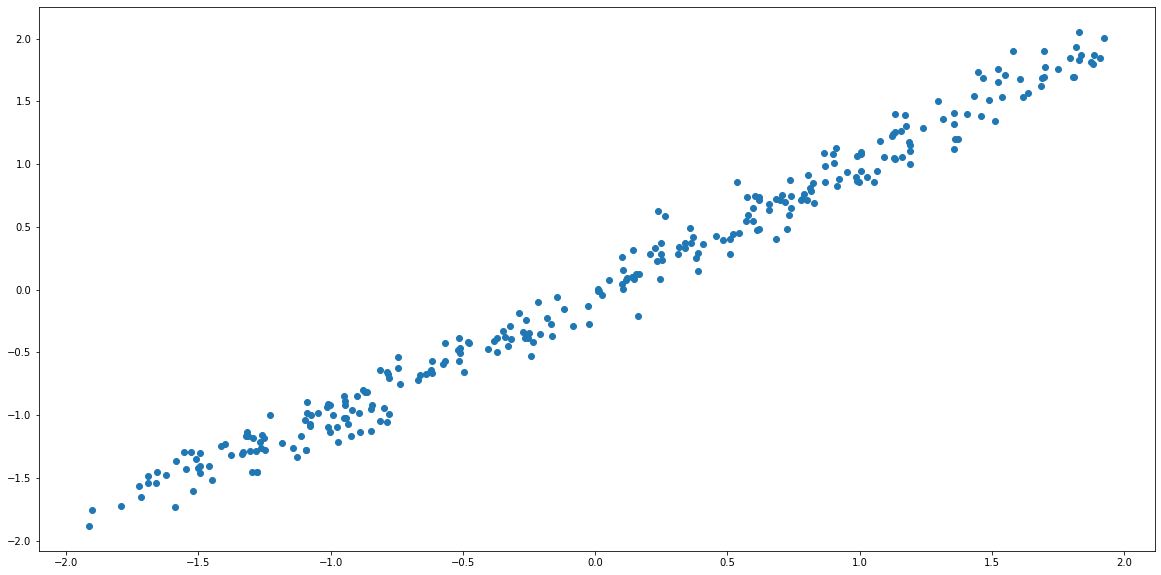

In [144]:
resids = model.y_test - model.ols.predict(model.X_test)

plt.figure(figsize=(20,10))
plt.scatter(model.y_test, model.ols.predict(model.X_test))
plt.show()

plt.figure(figsize=(20,10))
plt.scatter(model.y_test[10500:], model.ols.predict(model.X_test)[10500:])
plt.show()

And I'm going to check its distribution as well as descriptive statistics:

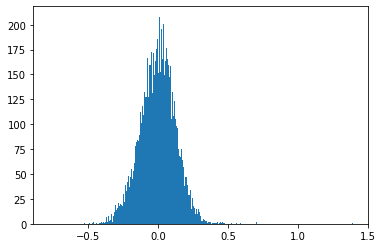

       Mean        Median    St. Dev.      Skew    Kurtosis    Durbin-Watson    JB-stat    JB-pvalue
-----------  ------------  ----------  --------  ----------  ---------------  ---------  -----------
-0.00312763  -8.40464e-05    0.128338  0.167121     5.84048          1.99363    3672.48            0
                 
             GF increasing    GF decreasing    GF two-sided       B-P
---------  ---------------  ---------------  --------------  --------
Statistic         0.995947         0.995947        0.995947  0.995947
P-values          0.559147         0.440853        0.881705  0.559147


In [145]:
res.functs.descriptive(resids, model.X_test, bins=25)

The residuals have both mean and median extremely close to 0, beautiful bell-shaped distribution, however with high kurtosis and moderate skew. Durbin-Watson test indicates no autocorrelation, Goldfeld-Quandt does not reject homoskedasticity and Jarque-Bera rejects null hypothesis about normality of residuals. Which I suspect that is caused by the high kurtosis.

In the next step I'm going to check the actual residplot:

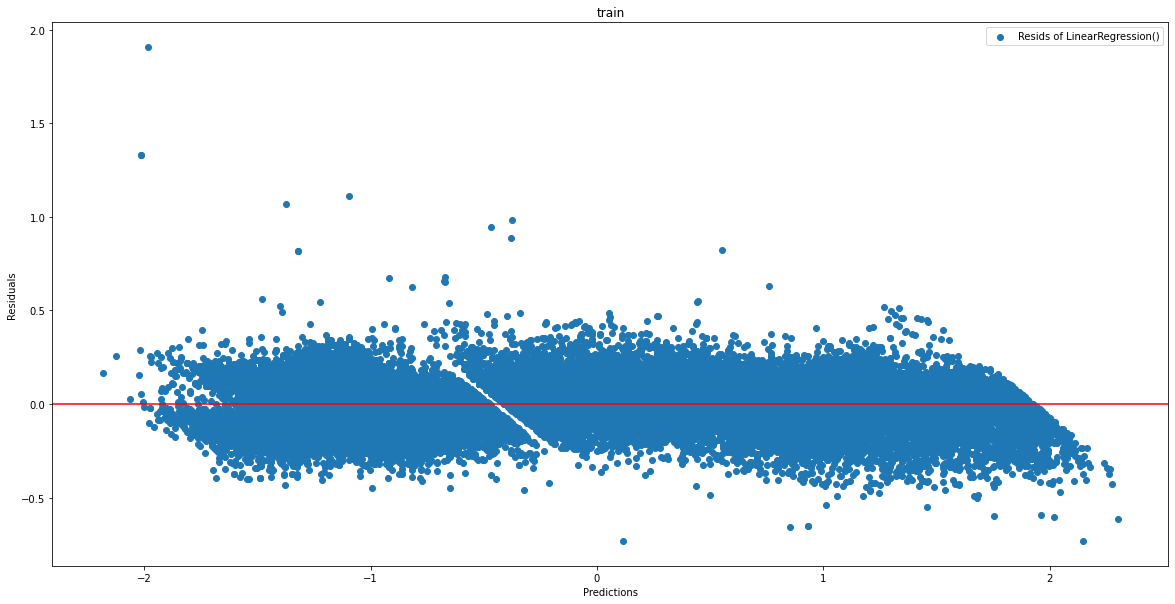

In [161]:
model.show_resids([model.ols])

The residuals do not seem to be entirely independently distributed, it means that there might be some nonlinearity that wasn't taken care of and/or the problem might be in the categorical variables.

I'm going to check for multicollinearity now with the VIF:

In [147]:
X_sm = sm.add_constant(X)
res.functs.calculate_vif(X_sm)

,Var,Vif
4,x,157.41
5,y,115.51
0,const,107.34
1,carat,48.92
6,z,33.80
18,clarity_SI1,14.70
21,clarity_VS2,14.23
19,clarity_SI2,11.45
8,cut_Ideal,11.09
20,clarity_VS1,10.74


There seems to be strong multicollinearity. Interestingly, ridge regression did not score significanly better than OLS, so I suspect that I will not be able to improve the model's accuracy. In any case, I'm going to simplify it.

Because OLS estimation has proven the most effective, checking statistical significance is quite simple. Nevertheless it should be remembered, that the residuals' kurtosis was high - the Jarque-Bera test also rejected normality (J-B statistics is based on, among others, kurtosis so I guess that it was the most important reason for it) and therefore, hence extreme deviations are likely, normal standard errors might be misleading and produce incorrect p-values. Because of that, I'm going to use heteroskedasticity-robust HC3 standard errors:

In [148]:
training = sm.add_constant(pd.DataFrame(model.X_train, columns=model.X_train2.columns))

model_sm = sm.OLS(exog=training, endog=model.y_train).fit(cov_type='HC3')
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 9.732e+04
Date:                Wed, 24 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:46:59   Log-Likelihood:                 27614.
No. Observations:               43154   AIC:                        -5.518e+04
Df Residuals:                   43130   BIC:                        -5.497e+04
Df Model:                          23                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6211      0.010    -60.492

Indeed, not all the variables are significant at the level of $\alpha=0.05$. I'm going to drop them now and redo the procedure:

In [149]:
model_sm = sm.OLS(exog=training.drop(columns=['table', 'z', 'x', 'y']), endog=model.y_train).fit(cov_type='HC3')
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.174e+05
Date:                Wed, 24 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:46:59   Log-Likelihood:                 27595.
No. Observations:               43154   AIC:                        -5.515e+04
Df Residuals:                   43134   BIC:                        -5.498e+04
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6195      0.010    -61.374

At the level of $\alpha=0.05$ all the variables seem to be significant. I'm going to check VIF again:

In [150]:
res.functs.calculate_vif(training.drop(columns=['table', 'z', 'x', 'y']))

,Var,Vif
0,const,104.16
14,clarity_SI1,14.54
17,clarity_VS2,14.11
15,clarity_SI2,11.30
16,clarity_VS1,10.62
4,cut_Ideal,9.82
5,cut_Premium,8.16
19,clarity_VVS2,7.49
6,cut_Very Good,7.34
18,clarity_VVS1,5.86


The VIF still looks high, but it's worth noticing that the highest values correspond to the dummy variables and the constant variable - it can be therefore accepted, especially that Ridge Regression did not seem to output any better results than OLS.

In [155]:
model_2 = LinearModelsSM(X=X.drop(columns=['table', 'z', 'x', 'y']), y=y)
model_2.train(intercept=True)

c:\users\micuk\pycharmprojects\makro\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
c:\users\micuk\pycharmprojects\makro\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
c:\users\micuk\pycharmprojects\makro\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
c:\users\micuk\pycharmprojects\makro\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

RESULTS FOR TRAINING SET:
+-------------+----------+----------+-----------+
|             |       R2 |      MSE |      RMSE |
+=============+==========+==========+===========+
| OLS         | 0.983674 | 0.12766  | 0.016297  |
+-------------+----------+----------+-----------+
| Ridge       | 0.983674 | 0.12766  | 0.016297  |
+-------------+----------+----------+-----------+
| Lasso       | 0.980635 | 0.139032 | 0.01933   |
+-------------+----------+----------+-----------+
| Elastic Net | 0.979496 | 0.143064 | 0.0204672 |
+-------------+----------+----------+-----------+
| TheilSen    | 0.97221  | 0.166554 | 0.0277402 |
+-------------+----------+----------+-----------+
| Huber       | 0.983597 | 0.127957 | 0.0163731 |
+-------------+----------+----------+-----------+
| WLS         | 0.979982 | 0.141358 | 0.019982  |
+-------------+----------+----------+-----------+
RESULTS FOR TESTING SET:
+-------------+----------+----------+-----------+
|             |       R2 |      MSE |      RMSE |

Ridge regression once again was marked as the best option, however its scores are practically the same as OLS's. As more simple models are usually preferred, I'm going to stay with OLS. I will check the residuals of the new model:

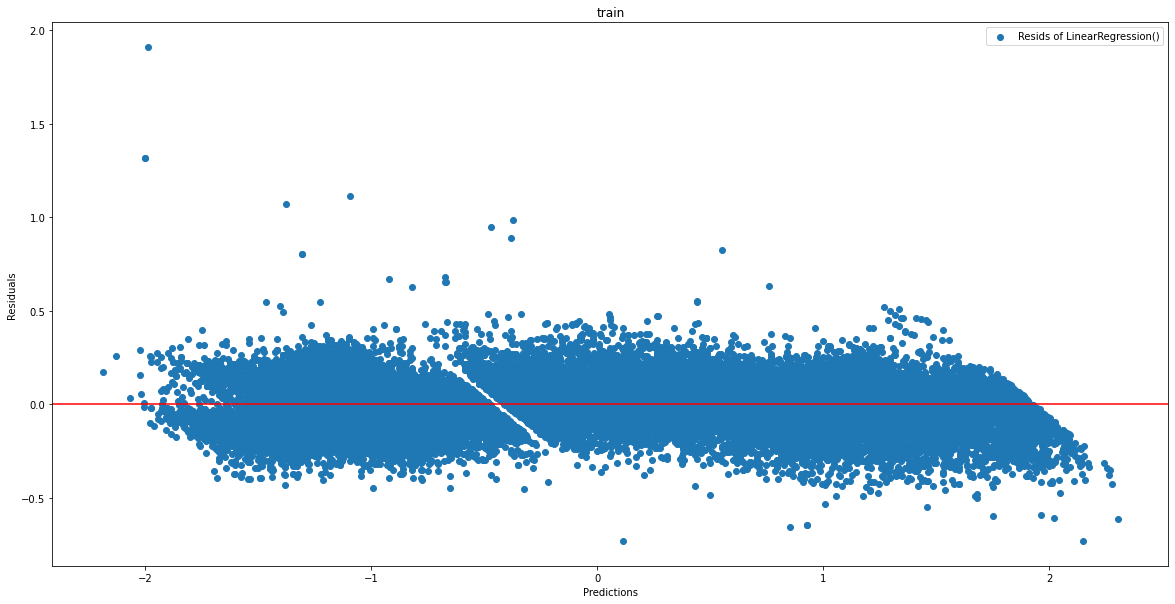

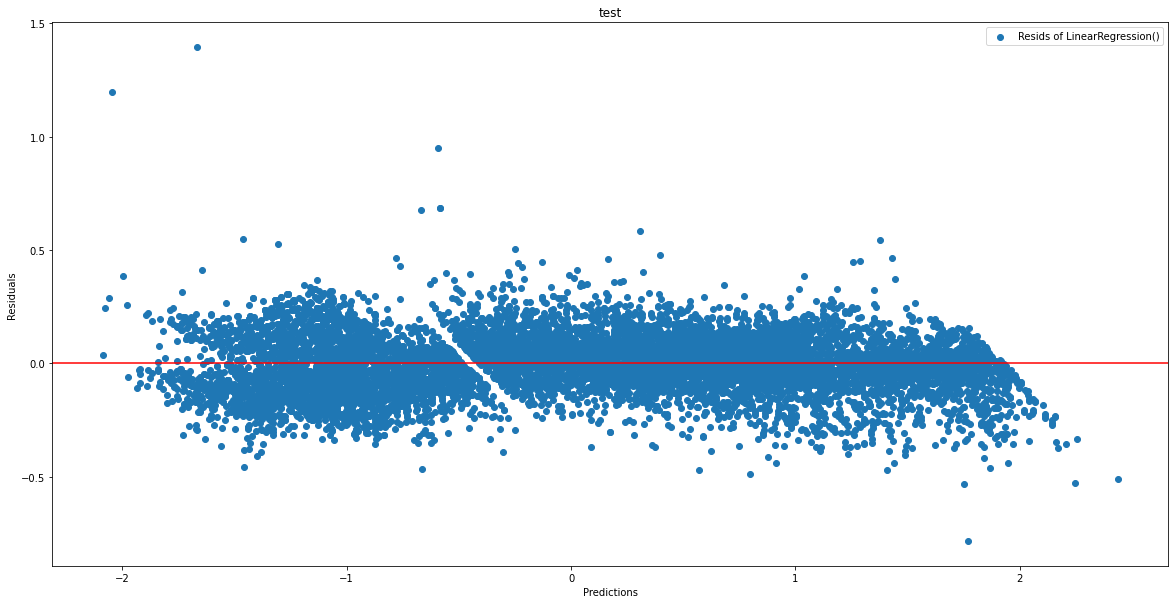

In [160]:
model_2.show_resids([model_2.ols], 'train')
model_2.show_resids([model_2.ols], 'test')

The residuals seem to be distributed more or less the same way as the primary model - there are still outliers and something like unexplained categorical variables or nonlinearity.

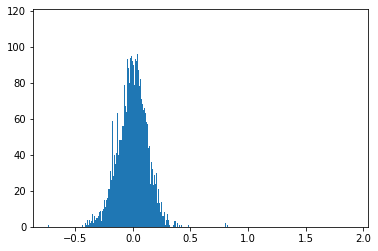

        Mean      Median    St. Dev.      Skew    Kurtosis    Durbin-Watson    JB-stat    JB-pvalue
------------  ----------  ----------  --------  ----------  ---------------  ---------  -----------
-2.00876e-17  0.00216408    0.127661  0.132351     5.56176          2.00225    11922.1            0
                 
             GF increasing    GF decreasing    GF two-sided        B-P
---------  ---------------  ---------------  --------------  ---------
Statistic        1.01898           1.01898         1.01898   1.01898
P-values         0.0836979         0.916302        0.167396  0.0836979
-----------------------------------------------------------------------------


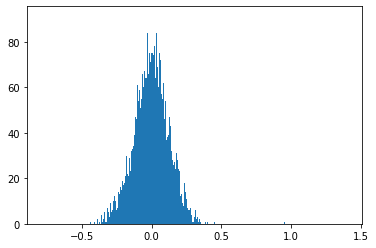

       Mean        Median    St. Dev.      Skew    Kurtosis    Durbin-Watson    JB-stat    JB-pvalue
-----------  ------------  ----------  --------  ----------  ---------------  ---------  -----------
-0.00312456  -0.000223103    0.128427  0.168469     5.82749          1.99358    3640.23            0
                 
             GF increasing    GF decreasing    GF two-sided       B-P
---------  ---------------  ---------------  --------------  --------
Statistic         0.990887         0.990887        0.990887  0.990887
P-values          0.63141          0.36859         0.737178  0.63141


In [163]:
res.functs.descriptive(model_2.y_train - model_2.ols.predict(model_2.X_train), model_2.X_train)
print('-----------------------------------------------------------------------------')
res.functs.descriptive(model_2.y_test - model_2.ols.predict(model_2.X_test), model_2.X_test)

In both training and testing sets there's no autocorrelation nor heteroskedasticity. The distribution of these residuals are not normal according to Jarque-Bera tests, they have high kurtosis. Since in both cases assumptions of OLS are met (with little respect to possible neglected nonlinearity), I'm going to check both models' error metrics to decide which model is the final one:

In [167]:
print('')
print('The first model')
print('-------------------')
res.functs.eval(model.y_test, model.ols.predict(model.X_test))
print('')
print('The second model')
print('-------------------')
res.functs.eval(model_2.y_test, model_2.ols.predict(model_2.X_test))


The first model
-------------------
            r2           me      mse       rmse        mae      mape
-----  -------  -----------  -------  ---------  ---------  --------
Value  0.98361  -0.00312763  0.12837  0.0164789  0.0996062  0.712528

The second model
-------------------
             r2           me       mse       rmse       mae      mape
-----  --------  -----------  --------  ---------  --------  --------
Value  0.983587  -0.00312456  0.128459  0.0165018  0.099691  0.711849


Both of the models have extremely similar error scores on the testing set. In this case, using any of them would give equivalent forecasts. Nevertheless, the second model requires less explanatory variables, and is therefore preferred.

The second OLS model is therefore sufficient to provide accurate forecasts as it generalizes the knowledge practically evenly between training and testing datasets and its metrics are at satisfatory level.

If the possible neglected nonlinearity is to be handled (in my opinion, it is too slight to bother), certain nonlinear machine learning algorithm could be used.